# Number Detection using OpenCV and Decision Trees 
*MNIST dataset*
You can access the dataset here: [Kaggle MNIST dataset](https://www.kaggle.com/competitions/digit-recognizer/data)

> This notebook uses the MNIST number classification dataset to recognizer numbers with the help of OpenCV and Random Forest Classifier. 


In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

> Reading the data

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
train.shape

(42000, 785)

### Explaination of the MNIST dataset
> - MNIST is a famous dataset that consists of handwritten numbers for classification. 
-It consists of 785 columns in total where 1 of it is the `label` (the number that represents the specific row) and the rest 784 columns are `pixels` of the image. 
<br></br>
- **Why 784 pixels of the image?** 
- The images that we are using for classification of numbers are of 28x28 pixels. Something like this: 
<br></br>
<img src="http://i.imgur.com/rwMpFVu.png" height="200"></img>

> - To represent this 28x28 matrix in a dataset will be incovenient. Hence we turn this into a `single row` of 784 (28*28) containing all the digits shown in the image above. Like this- 
<br></br>
<img src="https://static.wixstatic.com/media/34bab5_2bf56349ff884c49bfe06edfb33eb1e9~mv2.png/v1/fill/w_910,h_267,al_c/34bab5_2bf56349ff884c49bfe06edfb33eb1e9~mv2.png" height="200"  width="500"></img>


> -Hence we turn the 2D matrix to a 1D matrix. This is called `Row Flattening`
- This 1D matrix is then added as a single row in our MNIST dataset widht 784 columns. 
- The **785th** column depicts the number that is represented by those 784 pixels.


### Entire model: 
<br></br>
<img src="http://gpucomputing.shef.ac.uk/static/img/intro_dl_sharc_dgx1/mnist_simple.png" height="200" ></img>

In [3]:
y=train['label']
X=train.drop('label',axis=1)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- In the MNIST dataset shown above, column `label` is the number that we have to predict while the rest of the columns are the pixels of that number. 

### Training the model

> We will be splitting our training data, 80% for training our model and 20% for testing it's accuracy

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

> The model input X requires a `Float` value while the output Y needs to be in the integer form (since integer values are predicted).

In [5]:
X_train = np.asarray(X_train).astype(np.float32)
y_train= np.asarray(y_train).astype(np.int64)
X_test = np.asarray(X_test).astype(np.float32)

> `Rtrees` is a class of OpenCV that helps us to implement Random Forest algorithm

In [6]:
import cv2
rtree = cv2.ml.RTrees_create()

> Hyperparameter tuning for our model

In [7]:
num_trees = 100 ## No. of trees for training our model
eps = 0.01 ## Stops the algorithm if this accuracy is reached (error rate=0.01)
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            num_trees, eps)
rtree.setTermCriteria(criteria) ## defines these criterias for the model rtree

> Sample tree for reference 
<br></br>
<img src="https://forum.huawei.com/enterprise/en/data/attachment/forum/202103/24/190400o09x7rhnnhy2yon7.png?1.png" height="300"><img>

In [8]:
rtree.setMaxCategories(len(np.unique(y_train))) ## max categories in our case: 10 (since numbers from 0 to 9 can be predicted)

In [9]:
rtree.setMinSampleCount(2) ## If the number of samples in a node is less than this parameter then the node will not be split.
## As shown in the image above, minimum number of samples required to split a node is 2. 

In [10]:
rtree.setMaxDepth(1000) ## Setting a maximum depth above which the tree won't be split. (Levels of the decision tree)

> After our hyperparameter tuning, we will be training our model.

In [11]:
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [12]:
rtree.getMaxDepth() ## Max depth of our tree after training our model is 25

25

In [13]:
a , y_hat = rtree.predict(X_test) ## Predicting the 20% of the data that we took for testing

In [14]:
print(a)

1.0


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat) 

0.9657142857142857

> Hence we got an accuracy of 96%, we can improve this by tuning the number of trees, depth, sample count etc. 

## Testing with actual images

> - Now we will be using an actual image for testing our model, to see how well it predicts. 
> - Since our dataset is for 28x28 pixel images, we resize our image to 28x28

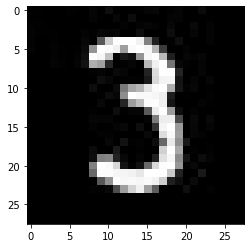

In [24]:
file = r'../input/mnistasjpg/testSample/testSample/img_142.jpg'
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

# Format Image
img_resized = cv2.resize(test_image, (28,28), interpolation=cv2.INTER_LINEAR)
plt.imshow(img_resized, cmap='gray') ## Displaying the image that we have to predict 

> - Now we flatten our image of 28x28 to convert it to a single vector of size 784 so that it fits our model. 
- Our model only accepts a single row of 784 features.

In [25]:
img_resized=img_resized.astype('float32')
img_resized -= img_resized.mean(axis=0)
img_resized = img_resized.flatten().reshape(1,784)

> - Predicting our image 

In [26]:
_, pred = rtree.predict(img_resized)

In [27]:
pred

array([[3.]], dtype=float32)